# Toxic Comment Classification
## Part1: Tfidf + Logistic Regression

### Overview of this project
1. <a href='#Section1'>Data Description</a>
2. <a href='#Section2'>Project Goal</a>
3. <a href='#Section3'>EDA</a>
4. <a href='#Section4'>Cleaning and Stemming</a>
5. <a href='#Section5'>TfidfVectorizer</a>
6. <a href='#Section6'>Logistic Regression</a>
7. <a href='#Section7'>More tuning and Extra analysis</a>
8. <a href='#Section8'>Summary so far</a>
9. <a href='#Section9'>Furture Directions</a>
 
_Please note that this project has not been completed, but there is <a href='#Section8'>Summary so far</a> at the end of notebook._

<a id= 'Section1'></a>
## 1. Data Description

- The dataset is comments from Wikipedia’s talk page edits https://simple.wikipedia.org/wiki/Wikipedia:Talk_page.
- The dataset files, train.csv and test.csv, were downloaded from a Kaggle Competition (by Jigsaw and Google) https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge 
- train.csv is the training set that contains comments with their id and 6 binary labels. 
- test.csv is the test set that contains comments and their id only. I have to predict the labels, toxicity probabilities.
- The training set includes 8 columns: 
   - id (comment id number)
   - comment_text (Wikipedia comments. Each comment was labeled by human raters for  6 types of toxic behaviors. The following 6 columns are the rated labels) 
   - toxic
   - severe_toxic
   - obscene 
   - threat
   - insult
   - identity_hate 
- Note that the 6 categories are not mutually exclusive.

<a id= 'Section2'></a>
## 2. Project Goal
Find an algorithm or create a model that predicts a probability of each type of toxicity for each comment the best.

<a id= 'Section3'></a>
## 3. EDA

I will do some brief exploratory data analysis using the training set.

In [218]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
import string
import re

In [219]:
train = pd.read_csv('train.csv') #training set
test = pd.read_csv('test.csv') #test set

In [220]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [221]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [222]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The count shows there are _159,571_ comments. The mean shows the proportions of toxic comments for each category:
  - Toxic:         9.58% 
  - Severe Toxic:  1.00%
  - Obcene:        5.29%
  - Threat:        0.30%
  - Insult:        4.94%
  - Identity hate: 0.88%
  
The proportions show this data set has very unblanced classes for each category of toxic behavior. Some of the categories like Threat (.30%), Indentity hate (.88%), and Severe Toxic (1.00%) are severely unbalanced. Thus, the validation methods such as train/test split or performance metrics should be carefully selected.

There seems to be no missing values. I will confirmed this in the next cell.

In [223]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [325]:
# Check test set as well
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [224]:
# Count the number of comments with only white spaces
empty_comment = 0 
for comment in train['comment_text']:
    if re.match('\s+', comment):
        empty_comment +=1
empty_comment

0

In [225]:
# Shorter code but more memory required
len([1 for comment in train['comment_text'] if re.match('\s+', comment)])

0

In [326]:
len([1 for comment in test['comment_text'] if re.match('\s+', comment)])

3

I also checked if there is any blank comment and I found none in the train set, but 3 in the test set. I will have to take care of these blank comments if they can cause a problem.

In [226]:
# Check some comments
for i in range(3):
    print("Sample comment {}".format(i),'\n', train['comment_text'][i])

Sample comment 0 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Sample comment 1 
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Sample comment 2 
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


It seems there are sometimes IP addresses or dates and times. Cleaning them might improve my predictions, but I will keep them there for now.

In [227]:
# check the length of each comment
lengths = np.vectorize(len)
text_len = lengths(train['comment_text'])

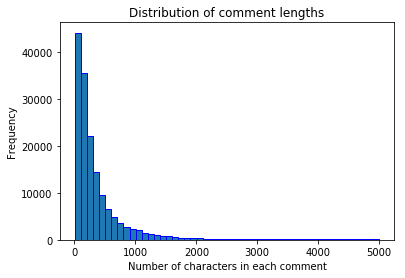

In [228]:
plt.hist(text_len, bins = 50,edgecolor='b')
plt.title('Distribution of comment lengths')
plt.xlabel('Number of characters in each comment')
plt.ylabel('Frequency')
plt.show()

The distribution is highly right-skewed. I will take log for y-axis to take a closer look at the right tail. 

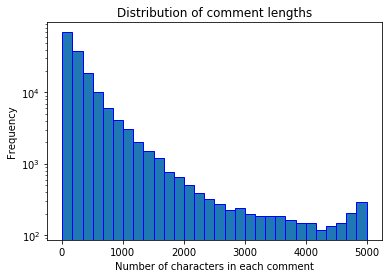

In [229]:
# with log scale for y
plt.hist(text_len, bins = 30, log =True, edgecolor='b')
plt.title('Distribution of comment lengths')
plt.xlabel('Number of characters in each comment')
plt.ylabel('Frequency')
plt.show()

In [230]:
print("Minimum text length: ", min(text_len), "characters")
print("Maximum text length: ", max(text_len), "characters")

Minimum text length:  6 characters
Maximum text length:  5000 characters


The comment length ranges from 6 to 5000 characters. It looks like 5000 was the maximum number of characters that can be entered as a comment. Frequency decreases as the number of characters increases, but it increases again after around 4000 characters.  I wonder what makes this pattern and whether comment lengths are related to the probability of toxicity. 

Let's first check comments with the maximum number of characters, 5000.

In [231]:
max_comment_idx,    = np.where(text_len == max(text_len))

In [232]:
max_comment_idx = list(max_comment_idx)
print(max_comment_idx)

[4174, 6201, 8705, 9673, 10769, 12895, 16643, 18183, 22378, 25702, 27148, 28855, 34422, 35316, 42061, 46197, 46583, 47715, 53408, 56063, 56441, 56834, 57173, 63392, 70544, 72192, 74753, 75165, 76184, 82636, 86251, 86529, 93952, 96267, 121718, 123571, 128782, 131729, 133254, 156032, 156437, 158970]


In [233]:
train.loc[max_comment_idx,:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0
6201,1091689382892a88,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,1,1,0,0,0
8705,171ebb2b785f72bd,BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL...,1,0,0,0,0,0
9673,199912b2d9973a21,"FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHE...",1,1,1,0,1,0
10769,1c7b06718dcc3b86,TOMMY2010 IS A NIGGER TOMMY2010 IS A NIGGER TO...,1,0,0,0,1,1
12895,222aad8a931bcfdf,I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME...,1,0,0,0,1,0
16643,2be09ad5ce9a8a85,'''Hi Wikipedia!!Hi Wikipedia!!Hi Wikipedia!!H...,0,0,0,0,0,0
18183,300b0c81ea94e02d,Hey guys I love chicken rice=)Hey guys I love ...,0,0,0,0,0,0
22378,3b0e1b13380cdd7a,I fuck niggas! I fuck niggas! I fuck niggas! I...,1,1,1,0,1,1
25702,44096c9bd35a200d,"""....would you prefer expressing my frustratio...",0,0,0,0,0,0


In [234]:
#train['comment_text'][max_comment_idx]

These comments that reached the character limit look mostly toxic or nonsense otherwise!! These comments also show there are many repeated words, seneteces, or letters, and bad words attached together without space, which could make analysis difficult. Taking care of these problematic words can be very helpful for toxic comment predictions.

In [235]:
train.loc[max_comment_idx].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.761905,0.428571,0.428571,0.047619,0.452381,0.119048
std,0.431081,0.500870,0.500870,0.215540,0.503761,0.327770
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The comments with the maximum number of characters had much higher proportions of bad comments. The original proportions of bad comments from all comments are in parentheses for easy comparisons.  

  - Toxic:         76.2% (9.58%) 
  - Severe Toxic:  42.9% (1.00%)
  - Obcene:        42.9% (5.29%)
  - Threat:        4.8%  (0.30%)
  - Insult:        45.2% (4.94%)
  - Identity hate: 11.9% (0.88%)
  

These results made me wonder how different the distribution of comment lengths is between toxic and nontoxic comments and whether longer comments are more likely toxic. I will check this after making some extra columns we need.

In [236]:
#del train['num_char']
#train.head()

In [237]:
# Create a new column with value 1 if any toxic category is 1 and value 0 otherwise
ints = np.vectorize(int)
bad = ints(train.iloc[:,2:].sum(axis=1) > 0)
len(bad)

159571

In [238]:
np.mean(bad)

0.10167887648758234

In [239]:
# Make a new dataframe with extra columns, 'num_char' and 'bad'
train_ExtraFeature = train.copy() # needed copy() not to change the original dataframe train
train_ExtraFeature['num_char'] = text_len
train_ExtraFeature['bad'] = bad

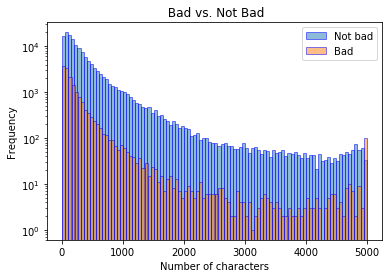

In [240]:
# Distributions of number of characters (Bad vs. Not Bad)
Bad = train_ExtraFeature[train_ExtraFeature['bad']==1]['num_char']
NotBad = train_ExtraFeature[train_ExtraFeature['bad']==0]['num_char']
plt.hist(NotBad, bins=100, log = True, alpha=0.5, label='Not bad',edgecolor ='b')
plt.hist(Bad, bins=100, log = True, alpha=0.5, label='Bad',edgecolor ='b')
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Number of characters')
plt.title(' Bad vs. Not Bad')
plt.show()

This combined histogram shows distributions of comment lengths separately for bad and not bad comments. This shows the increase after 4000 characters shown in the earlier histogram for all commments was mainly from bad comments. The proportion of bad comments tends to be higher for short or extremely long comments than for moderate length comments.

In [241]:
categories =['toxic', 'severe_toxic', 'obscene', 
             'threat', 'insult', 'identity_hate']

In [242]:
# With outliers

#for category in categories:
#    train_ExtraFeature.boxplot('num_char',category)
#    plt.title('')
#    plt.ylabel('Number of Characters')
#plt.show()

The boxplots for all comments were somewhat difficult to show patterns due to too many outliers with long comments, so I will check boxplots without outliers. Later I will check the long comments separately.

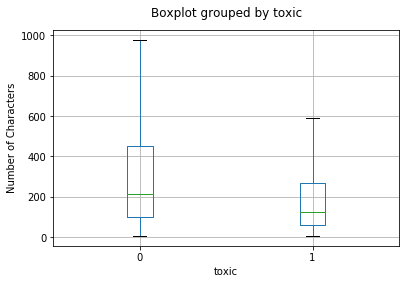

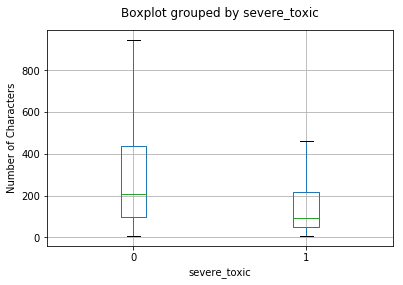

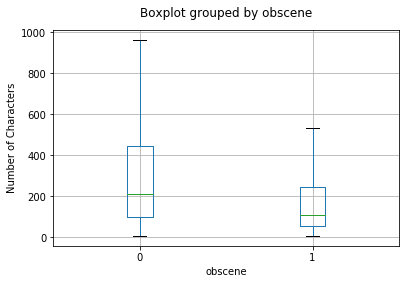

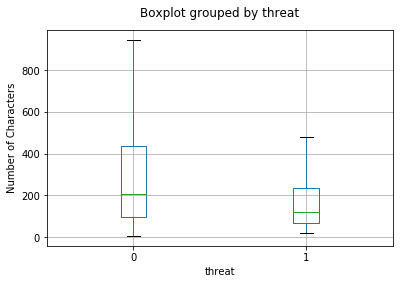

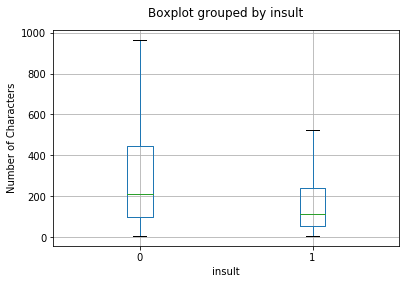

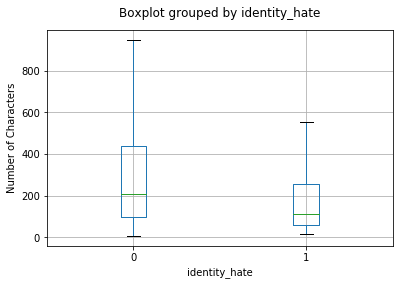

In [243]:
# Without outliers
for category in categories:
    train_ExtraFeature.boxplot('num_char',category, showfliers = False)
    plt.title('')
    plt.ylabel('Number of Characters')
plt.show()

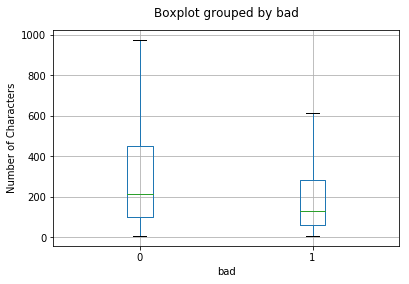

In [244]:
# Using the new column 'bad'
train_ExtraFeature.boxplot('num_char','bad', showfliers = False)
plt.title('')
plt.ylabel('Number of Characters')
plt.show()

These plots without outliers show that bad comments tend to be shorter rather than longer. However, the length of comments does not seem to be significantly different; the side by side boxes overlap substantially for all categories.

Now I will check boxplots for the comments with over 1000 characters or more since most outliers fall above 1000 characters.

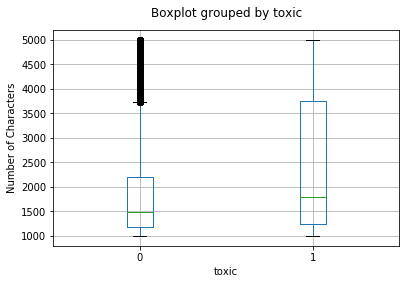

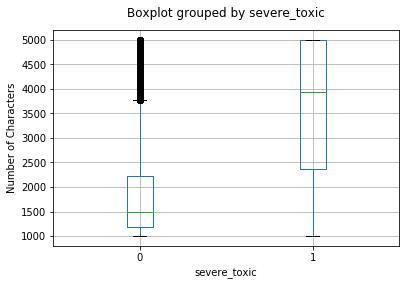

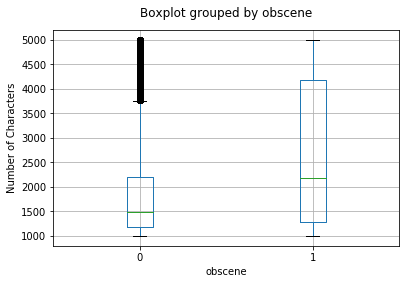

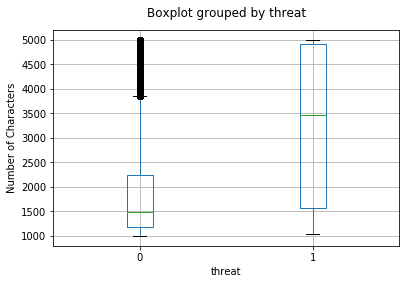

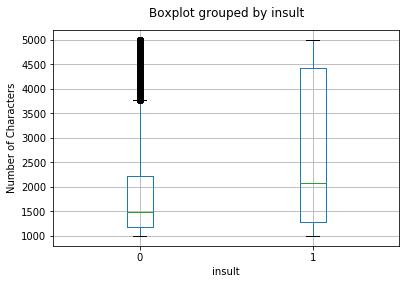

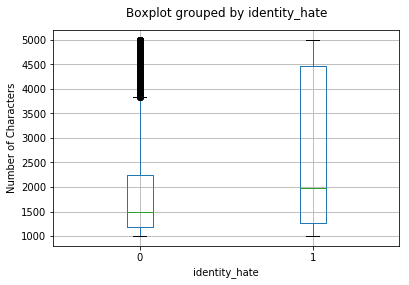

In [245]:
# Comments with 1000 characters or more
for category in categories:
    train_ExtraFeature[train_ExtraFeature['num_char']>1000].boxplot('num_char',category)
    plt.title('')
    plt.ylabel('Number of Characters')
plt.show()

If we only consider comments with over 1000 characters, bad comments tend to be longer!! However, again the difference does not seem to be significant except for severe toxic comments. The boxes for severe toxic and not severe toxic comments are not overlapping. In other words, severe toxic comments are much longer than not severe toxic comments if comments are longer than 1000 characters. Moreover, the extremely long comments are outliers for not bad comments while they are not outliers for bad comments. 

Although some patterns are found in this comment length analysis, I am not sure whether using the length of comment would be helpful for toxic comment predictions at this point.

In [246]:
#Let's check more extreme cases where comments have over 4000 characters. 
#Recall that the histogram of comment lengths for all comments had an increase after 4000 characters and 
#I found the increase is due to bad comments. 

# Comments with 4000 characters or more
#for category in categories:
#    train_ExtraFeature[train_ExtraFeature['num_char']>4000].boxplot('num_char',category)
#    plt.title('')
#    plt.ylabel('Number of Characters')
#plt.show()

In [247]:
# Comments with 4000 characters or more
#train_ExtraFeature[train_ExtraFeature['num_char']>4000].boxplot('num_char','bad')
#plt.title('')
#plt.ylabel('Number of Characters')
#plt.show()

#As expected, bad comments tend to be longer than not bad comments if only extremely long comments are considered. 

<a id='Section4'></a>
## 4. Cleaning and Stemming

Here I will clean text comments and apply stemming.

In [248]:
# Get pandas series out of data frames 
train_comment = train['comment_text']
test_comment = test['comment_text']

### Trying out with one comment

To develope each step, I will first use only one comment and then apply all steps to all comments. 

In [249]:
sample_comment = train['comment_text'][0]
print(sample_comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [250]:
# remove punctuations
sample_comment = re.sub(r'[^\w\s]','',sample_comment)
print(sample_comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827


In [251]:
# split text into words
word_list = sample_comment.split()
print(word_list)

['Explanation', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', 'They', 'werent', 'vandalisms', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', 'And', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'Im', 'retired', 'now892053827']


In [252]:
# apply stemmer and combine them again
stemmer= SnowballStemmer("english")

words = ""
for word in word_list:
    if word != "":
        word_stemmed = stemmer.stem(word)
        words += word_stemmed + " "
print(words)

explan whi the edit made under my usernam hardcor metallica fan were revert they werent vandal just closur on some gas after i vote at new york doll fac and pleas dont remov the templat from the talk page sinc im retir now892053827 


### Apply all steps to every comment

Now it' time to apply the above steps to every comment in the training set. First, I will make a function that combines all the steps.

In [253]:
def text_preprocessing(text):
    #remove punctuations
    text_string = re.sub(r'[^\w\s]','',text)
    #split text into words
    word_list = text_string.split()
    #apply stemmer and combine them again
    stemmer= SnowballStemmer("english")
    words = ""
    for word in word_list:
        if word != "":
            word_stemmed = stemmer.stem(word)
            words += word_stemmed + " "
    return words

In [254]:
print("Original text:","\n", train['comment_text'][0])
print()
print("Processed text:","\n", text_preprocessing( train['comment_text'][0]))

Original text: 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Processed text: 
 explan whi the edit made under my usernam hardcor metallica fan were revert they werent vandal just closur on some gas after i vote at new york doll fac and pleas dont remov the templat from the talk page sinc im retir now892053827 


Great! The function works well for one text. Now it's time to apply the preprocessing function to all comments in the training set.

In [255]:
#Check original comments in the training set
train_comment.head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [256]:
%%time
# stemming all comments in the training set
train_comment_stemmed = train_comment.apply(text_preprocessing)

Wall time: 1min 48s


In [257]:
train_comment_stemmed.head(10)

0    explan whi the edit made under my usernam hard...
1    daww he match this background colour im seem s...
2    hey man im realli not tri to edit war it just ...
3    more i cant make ani real suggest on improv i ...
4    you sir are my hero ani chanc you rememb what ...
5    congratul from me as well use the tool well talk 
6           cocksuck befor you piss around on my work 
7    your vandal to the matt shirvington articl has...
8    sorri if the word nonsens was offens to you an...
9    align on this subject and which are contrari t...
Name: comment_text, dtype: object

The texts in the test set should be also stemmed since words in the test set should be vectorized and transformed into a feature matrix as well.

In [258]:
%%time
# stemming all comments in the test set
test_comment_stemmed = test_comment.apply(text_preprocessing)

Wall time: 1min 34s


In [259]:
test_comment_stemmed.head()

0    yo bitch ja rule is more succes then youll eve...
1              from rfc the titl is fine as it is imo 
2                         sourc zaw ashton on lapland 
3    if you have a look back at the sourc the infor...
4                    i dont anonym edit articl at all 
Name: comment_text, dtype: object

Done with cleaning and stemming! Now let's move on to the vectorization part.

<a id='Section5'></a>
## 5. TfidfVectorizer
A vectorizer converts a collection of text documents into a numerical (sparse) matrix with 1 row per document and 1 column per token (e.g. word). I will use the Tf-idf (term frequency inverse document frequency) vectorizer.

In [260]:
%%time
# Using stemmed comments
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000

vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))

train_feature_matrix = vectorizer.transform(train_comment_stemmed)
#test_feature_matrix = vectorizer.transform(test_comment_stemmed)

Wall time: 19.1 s


'token_pattern' and 'ngram_range' will be tuned later.

In [261]:
# this function will help checking the results at glance
def print_results():
    print("### Tuning hyper-parameters for {} ###".format(category))
    print()
    print("Best hyper-parameters on development set:")
    print(clf.best_params_)
    print()
    print("Grid search scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r" % (mean, std * 2, params))
    print()    

<a id='Section6'></a>
## 6. Logistic Regression

Logistic regression will be test as a classifier. I will tune some hyper-parameters, but more fine tuning will be done in the next section.

#### Performance measure
The performance measure selected is 'roc_auc' since the Kaggle competition uses the metric for evaluation. I do not believe AUC is a good measure for data with highky unbalanced classes, but the only way to evaluate my model using the test set is submitting my predictions to the leaderboard, which will let me know only AUC values. Note that high AUC scores (e.g., 0.98) from unbalanced data do not mean your model is actually predicting well. F1 or other scores could be still very bad!!! For this reason, I will check some other performance measures as well.   

#### C
The hyper-parameter 'C' for LogisticRegression represents the inverse of regularization strength. I will use "coarse to fine" strategy to tune C and optimize C value for each type of toxicity.

#### Solver
If 'C'=100 is included in the hyper-parameter set, 'sag' gives bunch of convergence warnings, takes so much longer and the score for 'C'=100 was worse than lower C. Thus, I omitted 100 from the 'C' range. 

In [262]:
train.columns # just to coveniently copy and paste category names below

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [263]:
categories =['toxic', 'severe_toxic', 'obscene', 
             'threat', 'insult', 'identity_hate']

In [264]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'solver':['liblinear', 'sag'],'C': [.1,1,10]}
    log_reg = LogisticRegression(random_state =42)   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1, 'solver': 'sag'}

Grid search scores on development set:
0.9595 (+/-0.0048) for {'C': 0.1, 'solver': 'liblinear'}
0.9596 (+/-0.0047) for {'C': 0.1, 'solver': 'sag'}
0.9696 (+/-0.0028) for {'C': 1, 'solver': 'liblinear'}
0.9696 (+/-0.0028) for {'C': 1, 'solver': 'sag'}
0.9656 (+/-0.0022) for {'C': 10, 'solver': 'liblinear'}
0.9656 (+/-0.0022) for {'C': 10, 'solver': 'sag'}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 1, 'solver': 'sag'}

Grid search scores on development set:
0.9837 (+/-0.0029) for {'C': 0.1, 'solver': 'liblinear'}
0.9839 (+/-0.0025) for {'C': 0.1, 'solver': 'sag'}
0.9851 (+/-0.0033) for {'C': 1, 'solver': 'liblinear'}
0.9851 (+/-0.0032) for {'C': 1, 'solver': 'sag'}
0.9790 (+/-0.0050) for {'C': 10, 'solver': 'liblinear'}
0.9790 (+/-0.0049) for {'C': 10, 'solver': 'sag'}

### Tuning hyper-parameters for obscene ###

Best hyp

I found that 1 is the best inverse regularization level 'C' among .1, 1, and 10, but the more fine turning for C will be performed in the next section.   

The 'sag' solver performs slighly better than 'liblinear' except for Threat category. Since the difference between the two solvers for Threat is less than .0001 (when C is optimized), I will just use 'sag' for all categories. 

<a id="Section7"></a>
## 7. More Tuning and Extra analysis

I will fist do some tuning for C. 

In [265]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'C': [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag',random_state =42)   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 2}

Grid search scores on development set:
0.9640 (+/-0.0041) for {'C': 0.2}
0.9681 (+/-0.0033) for {'C': 0.5}
0.9696 (+/-0.0028) for {'C': 1}
0.9698 (+/-0.0025) for {'C': 2}
0.9682 (+/-0.0022) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9846 (+/-0.0026) for {'C': 0.2}
0.9852 (+/-0.0028) for {'C': 0.5}
0.9851 (+/-0.0032) for {'C': 1}
0.9844 (+/-0.0037) for {'C': 2}
0.9821 (+/-0.0044) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9818 (+/-0.0037) for {'C': 0.2}
0.9836 (+/-0.0034) for {'C': 0.5}
0.9843 (+/-0.0032) for {'C': 1}
0.9841 (+/-0.0031) for {'C': 2}
0.9823 (+/-0.0028) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

I found the better opimized C for each category, but C will be tuned even more after finding the best vectorizer.

### Tuning parameters for vectorizer

For the previous vectorizer, I used token_pattern=r'\w{1,}' to consider 1+ alphanumeric character words as a token and ngram_range=(1,1). In this section, I will try token_pattern=r'\w{2,}' to consider 2+ alphanumeric character words as a token and ngram_range=(1,2) to consider bigrams together with unigrams.

In [266]:
#try ngram_range=(1,2) instead of (1,1) to take bigrams into account
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,2),
                             max_features=10000) #consider top 10000
vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))
train_feature_matrix = vectorizer.transform(train_comment_stemmed)

In [267]:
%%time
for category in categories:
    train_labels = train[category]
    parameters = {'C':  [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag',random_state =42)   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9631 (+/-0.0044) for {'C': 0.2}
0.9669 (+/-0.0036) for {'C': 0.5}
0.9681 (+/-0.0031) for {'C': 1}
0.9679 (+/-0.0028) for {'C': 2}
0.9654 (+/-0.0027) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9840 (+/-0.0031) for {'C': 0.2}
0.9845 (+/-0.0035) for {'C': 0.5}
0.9843 (+/-0.0040) for {'C': 1}
0.9834 (+/-0.0047) for {'C': 2}
0.9807 (+/-0.0057) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9813 (+/-0.0036) for {'C': 0.2}
0.9831 (+/-0.0034) for {'C': 0.5}
0.9835 (+/-0.0032) for {'C': 1}
0.9831 (+/-0.0031) for {'C': 2}
0.9807 (+/-0.0027) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

Considering bigrams made the performance worse. Now I will try the different token_pattern while keeping ngram_range=(1,1).

In [268]:
%%time
#try token_pattern=r'\w{2,}' instead of r'\w{1,}'
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{2,}', #2+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000
vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))
train_feature_matrix = vectorizer.transform(train_comment_stemmed)

for category in categories:
    train_labels = train[category]
    parameters = {'C': [.2, .5, 1, 2, 5]}
    log_reg = LogisticRegression(solver = 'sag',random_state =42)   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=3)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 2}

Grid search scores on development set:
0.9637 (+/-0.0042) for {'C': 0.2}
0.9677 (+/-0.0034) for {'C': 0.5}
0.9692 (+/-0.0028) for {'C': 1}
0.9695 (+/-0.0025) for {'C': 2}
0.9678 (+/-0.0022) for {'C': 5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.5}

Grid search scores on development set:
0.9843 (+/-0.0023) for {'C': 0.2}
0.9847 (+/-0.0024) for {'C': 0.5}
0.9845 (+/-0.0027) for {'C': 1}
0.9836 (+/-0.0032) for {'C': 2}
0.9811 (+/-0.0037) for {'C': 5}

### Tuning hyper-parameters for obscene ###

Best hyper-parameters on development set:
{'C': 1}

Grid search scores on development set:
0.9814 (+/-0.0038) for {'C': 0.2}
0.9832 (+/-0.0036) for {'C': 0.5}
0.9838 (+/-0.0034) for {'C': 1}
0.9836 (+/-0.0032) for {'C': 2}
0.9817 (+/-0.0030) for {'C': 5}

### Tuning hyper-parameters for threat ###

Best hyper-parameters on development set:
{'C': 

Changing token_pattern to 2+ alphanumeric charaters also made predictions worse. I expect taht changing both taken_pattern and ngram_range would not imrove the performance, I will keep the original parameters used in the previous section.

I am done with tuning the vectorizer, so I will go back to tuning C for LogisticRegression.

### Fine tuning for C

In [269]:
%%time
vectorizer = TfidfVectorizer(analyzer ='word', 
                             stop_words='english',
                             sublinear_tf=True, #term-freq scaling
                             strip_accents='unicode', #works generally
                             token_pattern=r'\w{1,}', #1+ char words
                             ngram_range=(1,1),
                             max_features=10000) #consider top 10000

vectorizer.fit(pd.concat([train_comment_stemmed,test_comment_stemmed]))

train_feature_matrix = vectorizer.transform(train_comment_stemmed)
test_feature_matrix = vectorizer.transform(test_comment_stemmed) # finally we need this line

Wall time: 24.6 s


The optimized C in the previous section was 2, .5, 1, 2, 1, 1 for 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', respectively. Thus, I will do fine tuning around the best C of each category.

In [35]:
%%time
# Tune C for each category CV=10 
parameters_dic={'toxic':{'C':[1.1,1.2,1.3,1.4,1.5, 1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5]},
                'severe_toxic':{'C':[.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]},
                'obscene':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]},
                'threat':{'C':[1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5]}, 
                'insult':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]}, 
                'identity_hate':{'C':[.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5]}}
for category in categories:
    train_labels = train[category]
    parameters = parameters_dic[category]
    log_reg = LogisticRegression(solver='sag', random_state =42)   
    clf= GridSearchCV(log_reg, parameters, scoring='roc_auc', cv=10)
    clf.fit(train_feature_matrix, train_labels)
    print_results()

### Tuning hyper-parameters for toxic ###

Best hyper-parameters on development set:
{'C': 1.5}

Grid search scores on development set:
0.9708 (+/-0.0023) for {'C': 1.1}
0.9709 (+/-0.0022) for {'C': 1.2}
0.9709 (+/-0.0022) for {'C': 1.3}
0.9709 (+/-0.0022) for {'C': 1.4}
0.9709 (+/-0.0021) for {'C': 1.5}
0.9709 (+/-0.0021) for {'C': 1.6}
0.9709 (+/-0.0021) for {'C': 1.7}
0.9709 (+/-0.0021) for {'C': 1.8}
0.9708 (+/-0.0020) for {'C': 1.9}
0.9708 (+/-0.0020) for {'C': 2.0}
0.9708 (+/-0.0020) for {'C': 2.1}
0.9707 (+/-0.0020) for {'C': 2.2}
0.9707 (+/-0.0020) for {'C': 2.3}
0.9706 (+/-0.0020) for {'C': 2.4}
0.9706 (+/-0.0020) for {'C': 2.5}

### Tuning hyper-parameters for severe_toxic ###

Best hyper-parameters on development set:
{'C': 0.6}

Grid search scores on development set:
0.9845 (+/-0.0070) for {'C': 0.1}
0.9852 (+/-0.0066) for {'C': 0.2}
0.9855 (+/-0.0064) for {'C': 0.3}
0.9857 (+/-0.0064) for {'C': 0.4}
0.9857 (+/-0.0064) for {'C': 0.5}
0.9857 (+/-0.0064) for {'C': 0.6}
0.9857

Below was run to check the performance with the best parameters more easily.

In [270]:
%%time
best_C = {'toxic':1.5,'severe_toxic':.6,'obscene':1.2,
        'threat':1.8, 'insult':0.9, 'identity_hate':1.1}
score_all = []
for category in categories:
    train_labels = train[category]
    log_reg = LogisticRegression(solver='sag',random_state =42)   
    clf= GridSearchCV(log_reg, {'C':[best_C[category]]}, scoring='roc_auc', cv=10)
    clf.fit(train_feature_matrix, train_labels)
    print("Mean CV score on dev. set for %s is %0.4f" %(category,clf.best_score_))
    score_all.append(clf.best_score_)
print()
print("Mean CV score on dev. set for All categories is %0.4f" %np.mean(score_all))

Mean CV score on dev. set for toxic is 0.9709
Mean CV score on dev. set for severe_toxic is 0.9857
Mean CV score on dev. set for obscene is 0.9851
Mean CV score on dev. set for threat is 0.9845
Mean CV score on dev. set for insult is 0.9764
Mean CV score on dev. set for identity_hate is 0.9765

Mean CV score on dev. set for All categories is 0.9799
Wall time: 2min 5s


In [271]:
submission = pd.DataFrame()
submission['id']=test['id']

best_C = {'toxic':1.5,'severe_toxic':.6,'obscene':1.2,
        'threat':1.8, 'insult':0.9, 'identity_hate':1.1}
for category in categories:
    train_labels = train[category]
    clf = LogisticRegression(solver='sag', C=best_C[category],random_state =42)   
    clf.fit(train_feature_matrix, train_labels)
    submission[category] = clf.predict_proba(test_feature_matrix)[:,1] #second column!!
    
submission.to_csv('submission.csv', index=False)

I found AUC on the test set is .9745 on the leaderboard (not bad comparing to the score on the development set .9799). This is slightly worse than the last test score I got without cleaning and stemming (.9756) although the score on the development set was slightly better with stemming.

### Coefficient analysis
Here I check words with high and low coefficients to check what are most and least important words in the model. Since the last classifier(clf) used above was for Identity Hate, I will first utilize it to check which words had high coefficients for Identiy Hate comments.

#### Identity Hate

In [272]:
# Check coefficients
coeff = clf.coef_
print(coeff)

[[ 0.11838326 -0.07400097 -0.08635858 ...  0.          0.
   0.        ]]


In [273]:
# dictionary of term:feature_index key value pairs
voca_dic = vectorizer.vocabulary_ 

In [274]:
# Make a list of words odered by feature index
feature_words =[None]*len(voca_dic)
for word in voca_dic.keys():
    feature_words[voca_dic[word]]=word
#print(feature_words[:400])

In [275]:
# High coefficient words
sorted_voca = [word for _,word in sorted(zip(coeff[0],feature_words),reverse=True)]
print(sorted_voca[:100])

['nigger', 'gay', 'homosexu', 'nigga', 'jew', 'faggot', 'nazi', 'homo', 'muslim', 'black', 'racist', 'negro', 'fag', 'white', 'asian', 'hate', 'fuck', 'american', 'scum', 'rape', 'lesbian', 'turk', 'arab', 'stupid', 'dirti', 'indian', 'fucker', 'homophob', 'monkey', 'chink', 'shit', 'mexican', 'terrorist', 'jewish', 'pedophil', 'fat', 'dumb', 'niger', 'fool', 'niggaz', 'twat', 'women', 'disgust', 'sucker', 'bitch', 'boy', 'retard', 'bastard', 'cunt', 'allah', 'queer', 'burn', 'russian', 'littl', 'r', 'damn', 'antisemit', 'fuckin', 'slave', 'pig', 'lick', 'g', 'communist', 'slut', 'nl33er', 'like', 'u', 'ass', 'islam', 'irish', 'fing', 'babi', 'chines', 'death', 'countri', 'kill', 'hitler', 'idiot', 'peni', 'hoe', 'jesus', 'whore', 'akbar', 'motherfuck', 'filthi', 'slavic', 'fascist', 'filth', 'bag', 'anal', 'redneck', 'closet', 'huge', 'evil', 'hooker', 'trash', 'crazi', 'suck', 'gonna', 'devil']


These are indeed possible words for identity hate comments!

In [276]:
# Low coefficient words (negative coefficients)
sorted_voca = [word for _,word in sorted(zip(coeff[0],feature_words))]
print(sorted_voca[:100])

['articl', 'talk', 'thank', 'sourc', 'agre', 'redirect', 'mention', 'ani', 'editor', 'origin', 'discuss', 'better', 'consid', 'read', 'issu', 'list', 'clear', 'person', 'look', 'note', 'link', 'actual', 'understand', 'import', 'ok', 'pleas', 'suggest', 'alon', 'follow', 'word', 'chang', 'differ', 'happen', 'book', 'help', 'polici', 'mean', 'way', 'problem', 'befor', 'inform', 'edit', 'definit', 'sinc', 'isnt', 'cheer', 'new', 'remov', 'ive', 'time', 'case', 'check', 'marriag', 'say', 'open', 'utc', 'rot', 'worthless', 'exampl', 'end', 'use', 'id', 'state', 'fix', 'tag', 'notabl', 'didnt', 'week', 'number', '2008', 'page', 'review', 'refer', 'includ', 'accus', 'possibl', 'result', 'someon', 'howev', 'seen', 'sure', 'subject', 'posit', 'critic', 'answer', 'line', 'provid', 'histori', 'languag', 'certain', 'version', 'term', 'present', 'start', 'simpli', 'mani', 'project', 'did', 'deni', 'month']


These are words with the lowest coefficients (negative relationships) in the Hate Identity classification. They indeeed seem to be the words that are likely to appear in healthy comments.

In [277]:
# Words with low absolute values of coefficient (just out of curiosity)
sorted_voca = [word for _,word in sorted(zip(list(map(abs,coeff[0])),feature_words))]
#sorted_voca = [(coef,word) for coef,word in sorted(zip(list(map(abs,coeff[0])),feature_words))
print(sorted_voca[:100])

['19025427492', '439enter', '5h1t', '5hut', '5uck5', '8hi', 'aaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaafuck', 'adsydfiusagjfasfsduyaidfasgiudf', 'againdo', 'allumungi', 'analan', 'anarchistfuck', 'answershi', 'apparition11', 'asdf', 'asspi', 'ayden', 'aysen', 'azzholeseat', 'b00ll00x', 'ballsbal', 'ballshut', 'barbercallum', 'bastardshel', 'bitchbot', 'blaa', 'boabi', 'bola', 'bonergasm', 'booobsashtonsimmon', 'border8px', 'buttslut', 'c0pyr1ght', 'cawk', 'chhetri', 'chhetripadam', 'chodethi', 'clustercuntfartymcflyupmycuntholebastardfuck', 'cockebaum', 'cockjeremi', 'comnuistsscrew', 'cuntass', 'cuntnlu', 'cοck', 'd0wn', 'daiki', 'dann', 'deuschebag', 'dhe', 'dickdumbass', 'diefuk', 'disputerez', 'dixz', 'donkeysex', 'drogon', 'dutroux', 'ee용개형', 'faceruth', 'faggeorg', 'faggotgay', 'faggtblah', 'fagsgod', 'fb1', 'ff0000', 'fgtyou', 'freakbosisto', 'fuckerfuck', 'fuckfuck', 'fuckshit', 'fucksmisterwiki', 'fvcker', 'gayyour', 'gentlti', 'ghobrialyoussef', 'go0ver',

Interesting! These are the 100 words that had coefficients closest 0 (the commented out line actually showed their coefficients are all 0.0). This shows how people can create bad words that can pass a filter! (e.g., replacing s by 5) These words can contribute to false negatives when classifying toxic comments. 

#### Toxic

I will repeat the above analysis for 'toxic' category since most of bad comments (with label 1 for any of categories) were labeled as 'toxic' comments.

In [283]:
# Only 'toxic' category
best_C = {'toxic':1.5 ,'severe_toxic':.6,'obscene':1.2,'threat':1.8, 'insult':0.9, 'identity_hate':1.1}
category ='toxic'
train_labels = train[category]
clf = LogisticRegression(solver='sag', C=best_C[category],random_state =42)   
clf.fit(train_feature_matrix, train_labels)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [285]:
# Check coefficients
coeff = clf.coef_
print("coefficients:\n", coeff)
print()
# dictionary of term:feature_index key value pairs
voca_dic = vectorizer.vocabulary_ 

# Make a list of words odered by feature index
feature_words =[None]*len(voca_dic)
for word in voca_dic.keys():
    feature_words[voca_dic[word]]=word
#print(feature_words[:400])

# High coefficient words
sorted_voca = [word for _,word in sorted(zip(coeff[0],feature_words),reverse=True)]
print("High coefficient words:\n", sorted_voca[:100])
print()
# Low coefficient words (negative coefficients)
sorted_voca = [word for _,word in sorted(zip(coeff[0],feature_words))]
print("Low (negative) coefficient words:\n", sorted_voca[:100])
print()
# Words with low absolute values of coefficient (just out of curiosity)
sorted_voca = [word for _,word in sorted(zip(list(map(abs,coeff[0])),feature_words))]
#sorted_voca = [(coef,word) for coef,word in sorted(zip(list(map(abs,coeff[0])),feature_words))
print("Close to zero coefficient words:\n", sorted_voca[:100])

coefficients:
 [[-0.5734239  -0.13655471 -0.1488834  ...  0.          0.
   0.        ]]

High coefficient words:
 ['fuck', 'idiot', 'stupid', 'shit', 'suck', 'bullshit', 'ass', 'asshol', 'bitch', 'crap', 'dick', 'faggot', 'peni', 'bastard', 'moron', 'pathet', 'nigger', 'cunt', 'fucker', 'jerk', 'gay', 'shut', 'dumbass', 'hell', 'cock', 'motherfuck', 'retard', 'loser', 'fag', 'dumb', 'pussi', 'fuckin', 'racist', 'piss', 'dickhead', 'liar', 'kill', 'fool', 'jackass', 'sex', 'cocksuck', 'nazi', 'hate', 'wtf', 'damn', 'sick', 'pig', 'homosexu', 'whore', 'goddamn', 'die', 'bloodi', 'douchebag', 'garbag', 'hypocrit', 'scum', 'wanker', 'f', 'fing', 'vagina', 'ars', 'fat', 'fk', 'disgust', 'fuckhead', 'dirti', 'nerd', 'fck', 'prick', 'fascist', 'fart', 'pedophil', 'freak', 'ugli', 'donkey', 'dipshit', 'anal', 'screw', 'fcking', 'porn', 'rubbish', 'rape', 'coward', 'imbecil', 'ridicul', 'fuk', 'monkey', 'nigga', 'shame', 'stink', 'mental', 'lick', 'butt', 'shitti', 'masturb', 'ahol', 'homo', '

The results are pretty similar to what I found with 'identity_hate' except that high coefficient words are more general bad words rather than ones with identity hate.

I will find out whether the disguised bad words with zero coefficients reallly contribute to false negatives when classifying toxic comments in the next section.

### Error Analysis

I will do some error analysis using only 'toxic' category.

In [ ]:
train_labels = train['toxic']
clf = LogisticRegression(solver='sag', C=1.5,random_state =42)   
clf.fit(train_feature_matrix, train_labels)

In [316]:
pred = pd.DataFrame()
pred['comment_text']=train['comment_text']
pred['comment_stemmed'] =train_comment_stemmed
pred['toxic'] =train['toxic'] #actual label
pred['nontoxic_prob'] = clf.predict_proba(train_feature_matrix)[:,0] #how likely the label is 0 (i.e., nontoxic)
pred['toxic_prob'] = clf.predict_proba(train_feature_matrix)[:,1] #how likely the label is 1 (i.e., toxic)
pred.head()

,comment_text,comment_stemmed,toxic,nontoxic_prob,toxic_prob
0,Explanation\nWhy the edits made under my usern...,explan whi the edit made under my usernam hard...,0,0.989121,0.010879
1,D'aww! He matches this background colour I'm s...,daww he match this background colour im seem s...,0,0.993392,0.006608
2,"Hey man, I'm really not trying to edit war. It...",hey man im realli not tri to edit war it just ...,0,0.967178,0.032822
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make ani real suggest on improv i ...,0,0.999142,0.000858
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero ani chanc you rememb what ...,0,0.979509,0.020491


In [317]:
pred.describe()

,toxic,nontoxic_prob,toxic_prob
count,159571.000000,1.595710e+05,159571.000000
mean,0.095844,9.041555e-01,0.095844
std,0.294379,2.278643e-01,0.227864
min,0.000000,3.782308e-12,0.000019
25%,0.000000,9.554720e-01,0.005477
50%,0.000000,9.850813e-01,0.014919
75%,0.000000,9.945231e-01,0.044528
max,1.000000,9.999815e-01,1.000000


In [324]:
# Toxic, but low predicted probability of being toxic
pred[(pred['toxic']==1) & (pred['toxic_prob']<.1)]

,comment_text,comment_stemmed,toxic,nontoxic_prob,toxic_prob
12,Hey... what is it..\n@ | talk .\nWhat is it......,hey what is it talk what is it an exclus group...,1,0.913592,0.086408
151,"""\n\nSORRY PUCK BUT NO ONE EVER SAID DICK WAS ...",sorri puck but no one ever said dick was numbe...,1,0.947546,0.052454
159,"""\n\nUNBLOCK ME OR I'LL GET MY LAWYERS ON TO Y...",unblock me or ill get my lawyer on to you for ...,1,0.925851,0.074149
278,Hey why you are spreading misconceptions and t...,hey whi you are spread misconcept and tri to s...,1,0.910281,0.089719
330,God is dead\nI don't mean to startle anyone bu...,god is dead i dont mean to startl anyon but go...,1,0.959458,0.040542
503,I don't care what you say here. I don't believ...,i dont care what you say here i dont believ on...,1,0.958807,0.041193
519,I can tell you what the argument is about here...,i can tell you what the argument is about here...,1,0.952018,0.047982
590,"""\n\n Another crap article \nParrots what prom...",anoth crap articl parrot what promot websit of...,1,0.938979,0.061021
852,P.S. Are you a /b/tard?,ps are you a btard,1,0.902286,0.097714
1165,"""\n\nSo threatening to try to have me banned f...",so threaten to tri to have me ban for edit is ...,1,0.953405,0.046595


The above are toxic comments to be predicted as nontoxic due to their low predicted probability of being toxic.  As I saw in the words with close zero coefficients, there are again some disguised bad words. Some bad words were combined with neighboring words when punctuations are removed. For example, "hi,idiot" and "IDIOT!!!YOU" were transformed into hiidiot and idiotyou, respectively and "idiot" was actually a word with the second highest coefficient in the logistic regression. I believe taking care of theses words further can improve the performance.

<a id= 'Section8'></a>
## 8. Summary so far

#### Data
- From a Kaggle Competition (by Jigsaw and Google)
- Wikipedia comments labeled by human raters for toxic behavior
- 6 types of toxicity (toxic, severe toxic, obscene, threat, insult, identity_hate)

#### Goal of this project
Create a model that predicts a probability of each type of toxicity for each comment

#### EDA
- 159,571 training comments each with id and 6 types of toxicity labels
- 153,164 test comments with id
- Proportion for each type of toxicity (very unbalanced!!)
  - Toxic         9.6 % 
  - Severe Toxic  1.0 %
  - Obcene        5.5 %
  - Threat        0.3 %
  - Insult        4.9 %
  - Identity_hate 0.9 %
- Comment length from 6 to 5000 characters
- No missing values
- Ditributions of comment lengths were investigated
- The comments with the maximum number of characters are toxic or nonsense

#### Cleaning and Stemming 
- Steps for each doument:
  - Remove punctuations 
  - Split each document to make a word list
  - Stemming using SnowballStemmer("english")
  - Combine stemmed words back together
- Used apply() function to apply the above steps to all documents

#### TfidfVectorizer 
- __Vectorizer:__ convert a collection of text documents into a numerical matrix with 1 row per document and 1 column per token (e.g. word) by tokenizing, counting, normalizing

- __Tf-idf__ (term frequency inverse document frequency) weighting: frequency of a term in a given document multiplied by log((1+#documents)/(1+__#documents containing the term__)) + 1

- __Hyper-parameters:__
  - analyzer: {'word','char'}
  - stop_words: None, string {'english'}, or list 
  - sublinear_tf: boolean for applying sublinear tf  scaling (replace tf with 1+log(tf) )
  - token_pattern: regular expression denoting what constitutes a token e.g. r'\w{1,}' for 1+ char words
  - ngram_range: (min_n, max_n) e.g. (1,1), (1,2)
  - max_features: build a vocabulary that only consider the top max_features ordered by tf across the corpus

- __Tuned hyper-parameters for vectorizer:__
  - token_pattern: 1+ and 2+ char words
  - ngram_range: (1,1) and (1,2) 

- I used both train and test sets to fit the vectorizer and transfrom the sets separately.

#### Logistic Regression 
- __Hyper-parameters tuned:__
  - solver: 'liblinear' (default) vs. 'sag' (uses a Stochastic Average Gradient descent. faster than other solvers for large datasets). I found 'sag' is slightly better.
  - C: Inverse of regularization strength (I used "coarse to fine" strategy) I found the best C value for each type of toxicity.

- __GridSearchCV__ was for tuning, cross validation and stratified split. The split made training and developement sets from the given training set. The test set was given separately from Kaggle and was tested on the leaderboard. 
- __scoring:__ __'roc_auc'__ is used in the Kaggle competition, but AUC is not ideal for unbalanced classes. 
 - __Average AUC on dev. set: .9799__ 
   - The best C is between .6 to 1.8 (different for each type of toxicity). 
   - The test set tested on the leaderboard gave a similar AUC score (.9745).
   - C is higher for more unbalanced types of toxicity; less regularization is required for more unbalanced type.

#### Coefficient and Error analysis
- Words with high coefficients obtained by logistic regression are very toxic!
- Many of Words with coefficients close to zero are also toxic. They are disguised by word concatenations or numbers similar to letters.
- Error analysis also found some disguised bad words in the false negative comments and suggested possible improvements.

<a id= 'Section9'></a>
## 9.  Future directions

- I would like to take care of those bad words disguised by concatenating words or replacing letters with numbers of similar shapes.
- I will try more complex algorithms and models. In particular, I will make predictions using word embedding + LSTM in Keras (See Part2). 
- I will see if multi-task learning for multiple lables (6 by 1 vector label) is a possibility for a chosen model.
- I want to try performance measures other than AUC since the data set is very unbalanced. The best average F1 score on the development set was only .56 even though C was tuned again for F1 (not included in this notebook). However, if another metric is used, I cannot utilize the test set which can be evaluated only by AUC on the Kaggle leaderboard. This is huge loss since the test set is as big as the training set.